In [ ]:
#%pip install opencv-python
%pip install cameratransform  # https://cameratransform.readthedocs.io/en/latest/coordinate_systems.html

In [2]:
import cameratransform as ct

# cameratransform.RectilinearProjection(focallength_px=None, focallength_x_px=None, focallength_y_px=None, center_x_px=None, center_y_px=None, center=None, focallength_mm=None, image_width_px=None, image_height_px=None, sensor_width_mm=None, sensor_height_mm=None, image=None, sensor=None, view_x_deg=None, view_y_deg=None)
cam_intrinsics = ct.RectilinearProjection(focallength_px=320, image=(1920, 1080))
# tilt_deg = updown
# heading_deg = leftright
# roll_deg = Don't use.
cam_extrinsics = ct.SpatialOrientation(pos_x_m=0.0, pos_y_m=0.0, elevation_m=15.4, tilt_deg=85)
cam_distortion = ct.BrownLensDistortion(k1=None, k2=None, k3=None, projection=None)
cam = ct.Camera(cam_intrinsics, cam_extrinsics, cam_distortion)
cam.imageFromSpace([[-4.03, 43.96,  0.], [-8.57, 47.91, 0.], [0.0, 0.0, 0.0]])

array([[ 931.4278861 ,  621.60445222],
       [ 904.112363  ,  612.81543956],
       [ 960.        , 4197.61673688]])

In [3]:
import numpy
def random_rotation_basis():
    basis = numpy.random.random((3,3))
    while numpy.dot(basis[0,:], basis[1,:]) < 1e-6:
        basis = numpy.random.random((3,3))
    basis[2,:] = numpy.cross(basis[0,:], basis[1,:])
    basis[0,:] = numpy.cross(basis[2,:], basis[1,:])
    #print(abs(numpy.dot(basis[0,:], basis[1,:])) + abs(numpy.dot(basis[0,:], basis[2,:])) + abs(numpy.dot(basis[1,:], basis[2,:])))
    return basis

In [4]:
random_rotation_basis()

array([[-0.01855266, -0.02146193,  0.00967598],
       [ 0.19906615,  0.14782051,  0.70956342],
       [ 0.02948696, -0.02671073, -0.00270795]])

In [94]:
import math
import random
import cameratransform as ct
from dataclasses import dataclass, asdict, field

# Coordinate system:
# +x right, +y forward, +z up

@dataclass
class Example:
    marker_size_m: float
    fov_x_degrees: float = 0
    image_size: tuple[int, int] = field(default_factory = lambda: (0, 0))
    image_center: tuple[float, float] = field(default_factory = lambda: (0, 0))
    k: tuple[float, float, float] = field(default_factory = lambda: (0.0, 0.0, 0.0))
    forward_ray: tuple[float, float, float] = field(default_factory = lambda: (0.0, 0.0, 0.0))  # DEBUG: Lets us visualize the forward direction.
    translation_m: tuple[float, float, float] = field(default_factory = lambda: (0.0, 0.0, 0.0))
    rotation_xyz_degrees: tuple[float, float, float] = field(default_factory = lambda: (0.0, 0.0, 0.0))
    projection: list[list[float, float]] = field(default_factory = lambda: [])

def generate_datapoint(marker_size_m: float, roll_range: float = 10.0):
    x = Example(marker_size_m = marker_size_m)
    hw: float = marker_size_m / 2.0
    # 3D on the XY plane, clockwise starting from the top left.  -x left, +y forward, +z up.
    points = [
        [-hw, hw, 0.0],
        [hw, hw, 0.0],
        [hw, -hw, 0.0],
        [-hw, -hw, 0.0],
    ]
    camera_resolutions = [
        (64, 64),
        (128, 128),
        (160, 120),
        (256, 256),
        (320, 240),
        (512, 512),
        (640, 440),
        (640, 480),
        (800, 600),
        (1280, 720),
        (1920, 1080),
        (4080, 3060),
    ]

    #focal_length_mm = 1.0 + (100.0 * random.random() * random.random() * random.random())  # Sorta' uniform-ish distribution
    fov_x_degrees = 25.0 + (179.0-25.0)*random.random()
    x.fov_x_degrees = fov_x_degrees
    # fov -> focal length + sensor size OR 
    # focallength_x_px = image_width_px / (2 * tan(view_x_deg / 2))
    # focallength_px = focallength_mm / sensor_width_mm * image_width_px.
    
    image_size = random.choice(camera_resolutions)
    x.image_size = image_size
    max_center_jitter = 0.01 * image_size[0]
    center = [(image_size[0] * 0.5) + random.uniform(-max_center_jitter, max_center_jitter), (image_size[1] * 0.5) + random.uniform(-max_center_jitter, max_center_jitter)]
    x.image_center = center

    # cameratransform.RectilinearProjection(focallength_px=None, focallength_x_px=None, focallength_y_px=None, center_x_px=None, center_y_px=None, center=None, focallength_mm=None, image_width_px=None, image_height_px=None, sensor_width_mm=None, sensor_height_mm=None, image=None, sensor=None, view_x_deg=None, view_y_deg=None)
    #cam_intrinsics = ct.RectilinearProjection(focallength_px=320, image=(1920, 1080))
    cam_intrinsics = ct.RectilinearProjection(view_x_deg=fov_x_degrees, image=image_size, center=center)

    k1 = random.uniform(-1.0, 1.0)*random.uniform(-1.0, 1.0)
    k2 = random.uniform(-1.0, 1.0)*random.uniform(-1.0, 1.0)
    k3 = random.uniform(-1.0, 1.0)*random.uniform(-1.0, 1.0)
    x.k = (k1, k2, k3)
    cam_distortion = ct.BrownLensDistortion(k1, k2, k3, projection=None)

    while True:
        # https://cameratransform.readthedocs.io/en/latest/coordinate_systems.html
        # tilt_deg = updown,  heading_deg = leftright, roll_deg = Don't use.  heading = 0, tilt = 90 -> looking straight towards +Y, tilt = 0 -> looking towards -z
        # yaw = leftright, pitch = updown, roll = don't. yaw = 0, pitch = 0, roll = 0 -> looking straight towards +Y, pitch = -90 -> looking towards -z
        # Negative pitch = looking down towards -z.
        # We need to clamp our pitch between min and max atan2(z/y near) and atan2(z/y far)
        cam_x = random.uniform(-10.0, 10.0)
        cam_y = random.uniform(-10.0, 10.0)
        cam_z = random.uniform(0.1, 10.0)  # At least 10cm above flat.
        # Start by looking right at the target at the center, then jitter the rotations?  This will bias the model towards the center.

        x.translation_m = (cam_x, cam_y, cam_z)

        # Something in this lookat is messed up.  It works _some of the time_. 
        # TODO: Figure out why the 'lookat' is funky.
        cam_rx = math.degrees(math.atan2(cam_y, cam_z)) + random.uniform(-10.0, 10.0) # Pitch / Tilt.  Rotation around right axis +X.
        cam_ry = random.uniform(-10.0, 10.0) # Roll.  Rotation around axis +Y.
        cam_rz = math.degrees(math.atan2(-cam_x, -cam_y)) + random.uniform(-10.0, 10.0) # Yaw/Heading.  Rotation around axis +Z.
        
        #r_pitch_deg = math.degrees(random.uniform(min_rot, max_rot))
        x.rotation_xyz_degrees = (cam_rx, cam_ry, cam_rz)
        cam_extrinsics = ct.SpatialOrientation(pos_x_m=cam_x, pos_y_m=cam_y, elevation_m=cam_z, tilt_deg=cam_rx, heading_deg=cam_rz, roll_deg=cam_ry)
        cam = ct.Camera(cam_intrinsics, cam_extrinsics, cam_distortion)
        x.projection = cam.imageFromSpace(points)
        forward_offset, forward_ray = cam.getRay((image_size[0]/2, image_size[1]/2))
        x.forward_ray = forward_ray
        if numpy.any(numpy.isnan(x.projection)) or numpy.any(x.projection < 0) or numpy.any(x.projection[:, 0] > x.image_size[0]) or numpy.any(x.projection[:,1] > x.image_size[1]):
            continue
        break
    return x
    

In [95]:
example = generate_datapoint(0.1)
print(example)

Example(marker_size_m=0.1, fov_x_degrees=102.36714279492323, image_size=(320, 240), image_center=[161.33865016751832, 121.39190160885637], k=(0.14460614541474118, 0.1491892631376579, 0.24255316888353404), forward_ray=array([-0.56526134, -0.64146023, -0.51866046]), translation_m=(6.745030723921047, 7.228900611244995, 5.767753950078114), rotation_xyz_degrees=(58.733924166678484, -4.167968383214804, -138.5902012844532), projection=array([[266.04528176,  51.55556347],
       [243.68431567,  63.76916286],
       [221.57916648,  53.39266503],
       [243.92161024,  41.29840104]]))


In [7]:
#%pip install ipympl
#%matplotlib
#%matplotlib widget
#%matplotlib notebook
#%matplotlib inline
%matplotlib ipympl
#%pip install matplotlib-widget

In [8]:
import matplotlib.pyplot as plt

In [45]:
def plot(example: Example):
    # Generates a marker centered at the world origin along the XY plane.
    plt.ion()
    #with plt.ioff():
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111, projection='3d')
    bx = fig.add_subplot(121)

    # Also, project a point from the camera
    
    hw: float = example.marker_size_m / 2.0
    points_3d_x = [-hw, hw, hw, -hw, example.translation_m[0], example.translation_m[0]+example.forward_ray[0]]
    points_3d_y = [hw, hw, -hw, -hw, example.translation_m[1], example.translation_m[1]+example.forward_ray[1]]
    points_3d_z = [0, 0, 0, 0, example.translation_m[2], example.translation_m[2]+example.forward_ray[2]]
    point_colors = [0, 0, 0, 0, 0, 2]
    # Grab some test data.
    #from mpl_toolkits.mplot3d import axes3d
    #X, Y, Z = axes3d.get_test_data(0.05)
    #ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
    #plt.show()
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([0, 10])
    ax.scatter(xs=points_3d_x, ys=points_3d_y, zs=points_3d_z, c=point_colors)
    bx.set_xlim([0, example.image_size[0]])
    bx.set_ylim([0, example.image_size[1]])
    bx.scatter(x=example.projection[:,0], y=example.projection[:,1])
    
    #display(fig)
    #plt.show()
    #plt.close()
    return plt

Example(marker_size_m=0.1, fov_x_degrees=80.678780887666, image_size=(4080, 3060), image_center=[2066.4514069333636, 1511.673592749594], k=(0.37855526599779316, 0.21250444962774365, 0.1654113948970175), forward_ray=array([ 2.64438006e-02,  6.85570916e-04, -9.99690059e-01]), translation_m=(1.6074314890649646, 0.6901445193171867, 9.104426672213426), rotation_xyz_degrees=(-1.2228647711393226, -9.20475507757256, -109.24790779728811), projection=array([[1915.86719534,  729.02242873],
       [1909.11757354,  770.27734726],
       [1869.21182905,  762.64288461],
       [1875.88911919,  721.33892584]]))


<module 'matplotlib.pyplot' from '/home/joseph/.pyenv/versions/transformers/lib/python3.10/site-packages/matplotlib/pyplot.py'>

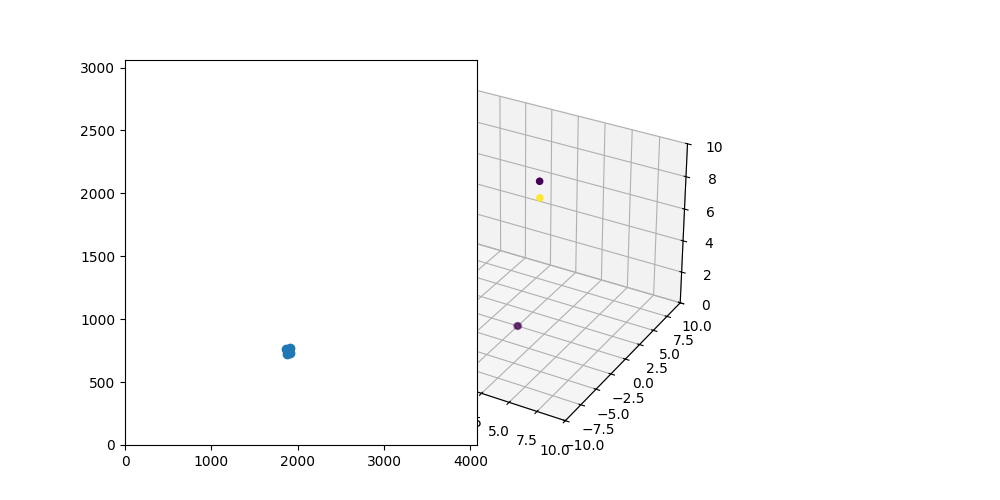

In [103]:
example = generate_datapoint(0.1)
print(example)
plot(example)

In [104]:
plt.close()